<a href="https://colab.research.google.com/github/progManu/Advanced-Topics-Machine-Learning/blob/main/Ultimate_AdvML_Challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

Advanced Topics in Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


During this first *challenge* of the *Advanced Machine Learning Course*, you will experiment with the development of a data analysis pipeline based upon various techniques seen during the lectures so far: some **unsupervised** (*e.g.* *PCA*, *kernel-PCA*) and some others **supervised** (*e.g.* *kernel SVM* and *Artificial Neural Networks* for classification).

In [36]:
'''
Importing necessary libraries
'''

import torch
import torchvision

import numpy as np

from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from scipy import linalg as LA
from scipy.spatial.distance import pdist, squareform

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ATML/CHALLENGE1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/ATML/CHALLENGE1'
/content/drive/MyDrive/ATML/CHALLENGE1


### The dataset

The dataset of interest for the *challenge* will be [*FashionMNIST*](https://github.com/zalandoresearch/fashion-mnist), an *MNIST*-like dataset of grayscale images of fashion items. Originally developed by Zalando Research in 2017 as a harder (yet *drop-in* compatible) replacement for the original *MNIST* dataset, it has been used in several papers and competitions since then.

Remember to consider the *dataset* mentioned below as the **training set** offered by *FashionMNIST*. Use the *test set* only at the end, to evaluate the overall accuracy of the pipeline!

In [37]:
'''
Downloading the original dataset (both trainset and testset and normalizing the values)
'''

BATCH_SIZE = 512

transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.2905,), (0.3547,))
])

trainset = torchvision.datasets.FashionMNIST('./data/', transform=transforms,  train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.FashionMNIST('./data/', transform=transforms, train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [38]:
'''
Loading only 5000 images (5000, 784) sampled with uniform probability from the trainset to be more computationally efficient
This set of values is available in my google drive: https://drive.google.com/drive/folders/18X99iR9Y2DvKeBkTzlghxm9EOngUAfGk?usp=share_link
'''

x_np = np.load('x_numpy.npy')
y_np = np.load('y_numpy.npy')

print(f'x_np shape: {x_np.shape}, y_np shape: {y_np.shape}')

x_np shape: (5000, 784), y_np shape: (5000,)


In [39]:
'''
Returns a touple (cluster_index, #elements_in_the_cluster) to get an idea of how data is distributed among classes and clusters
'''

def get_data_clusters(y):
  indexes_list = []
  for i in range(10):
    index = torch.where(y == i)
    indexes_list.append((i, index[0].size()))
  return indexes_list

In [40]:
'''
Returns the mean_value and the std of the cluster's size.
This is useful to estimate the data separation, because if the std is high,
that means that some clusters contain way more data than the others.
'''

def get_mean_and_std(y):
  indexes_list = []
  for i in range(10):
    index = torch.where(y == i)
    indexes_list.append(index[0].size())

  tensor_t = torch.tensor(indexes_list)
  tensor_t = tensor_t.flatten()
  tensor_t = tensor_t.float()

  return torch.std_mean(tensor_t)

In [41]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [42]:
get_data_clusters(torch.tensor(y_np)) # here we show that we have an uniform distribution of items in the dataset

[(0, torch.Size([452])),
 (1, torch.Size([500])),
 (2, torch.Size([505])),
 (3, torch.Size([500])),
 (4, torch.Size([500])),
 (5, torch.Size([523])),
 (6, torch.Size([511])),
 (7, torch.Size([471])),
 (8, torch.Size([543])),
 (9, torch.Size([495]))]

In [43]:
get_mean_and_std(torch.tensor(y_np))

(tensor(25.1529), tensor(500.))

### Section 1: Understanding data geometry

Load the dataset in the most suitable form for the tasks that follow. Then, perform the following steps, with the goal of developing a geometric understanding of the dataset:

1. Perform a (linear) *PCA* on the dataset, and plot the first two (or three!) principal components along with the true label. Comment on data separation.

2. Perform a *kernel-PCA* on the dataset with a Gaussian kernel, and plot the first two (or three!) principal components along with the true label. Try to tune the dispersion parameter of the kernel to obtain a good separation of the data. Comment.

3. Perform another *kernel-PCA* on the dataset with another kernel of your own choice, and plot the first two (or three!) principal components along with the true label. Try to tune the degree of the polynomial kernel to obtain a good separation of the data. Comment.

Whenever suitable, try to complement your analysis with some graphs!

**IMPORTANT NOTICE**: As some of you have reported, performing *kernel PCA* on the entire *FashionMNIST* dataset can be memory- and time- demanding (as it scales with the square of the number of datapoints!). In case you want to reduce such requirements, you can either:
  - Reduce the number of datapoints on which to perform *kPCA*, *e.g.* by slicing the randomly-shuffled dataset *(most effective!)*;
  - Reduce the size of the images in the dataset (*i.e.* by dropping even/odd rows/columns, or performing local pooling) *(somehow effective: you may want to try it if you do not have access to powerful compute, but still enjoy challenges!)*.

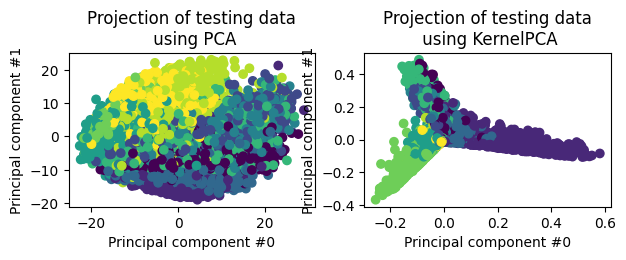

In [44]:
'''
Calculate PCA and rbf kernel PCA with 2 components and plotting the results
'''

pca = PCA(n_components=2)
kernel_pca = KernelPCA(
    n_components=2, kernel="rbf", gamma=1/100
)

x_pca_two_components = pca.fit(x_np).transform(x_np)
x_kernel_pca_two_components = kernel_pca.fit_transform(x_np)

fig, (pca_proj_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=2, figsize=(7, 2)
)

pca_proj_ax.scatter(x_pca_two_components[:, 0], x_pca_two_components[:, 1], c=y_np)
pca_proj_ax.set_ylabel("Principal component #1")
pca_proj_ax.set_xlabel("Principal component #0")
pca_proj_ax.set_title("Projection of testing data\n using PCA")

kernel_pca_proj_ax.scatter(x_kernel_pca_two_components[:, 0], x_kernel_pca_two_components[:, 1], c=y_np)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

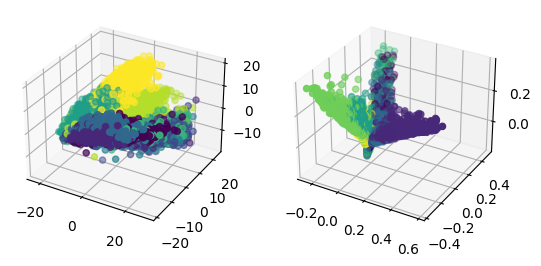

In [45]:
'''
Calculate PCA and rbf kernel PCA with 3 components and plotting the results
'''


pca = PCA(n_components=3)
kernel_pca = KernelPCA(
    n_components=3, kernel="rbf", gamma=1/100
)

x_pca_three_components = pca.fit(x_np).transform(x_np)
x_kernel_pca_three_components = kernel_pca.fit_transform(x_np)

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x_pca_three_components[:, 0], x_pca_three_components[:, 1], x_pca_three_components[:, 2], c=y_np)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(x_kernel_pca_three_components[:, 0], x_kernel_pca_three_components[:, 1], x_kernel_pca_three_components[:, 2], c=y_np)

plt.show()

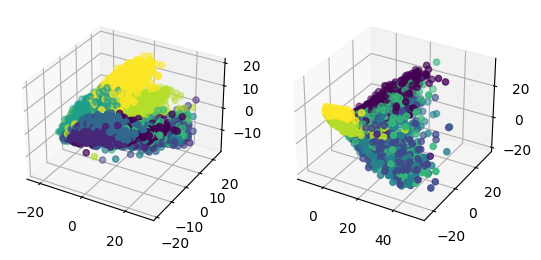

In [46]:
'''
Calculate PCA and polynomial kernel PCA with 3 components and plotting the results
'''


pca = PCA(n_components=3)
kernel_pca_poly = KernelPCA(
    n_components=3, kernel="poly", gamma=1/100
)

x_pca_three_components_another_ker = pca.fit_transform(x_np)
x_kernel_pca_three_components_another_ker = kernel_pca_poly.fit_transform(x_np)

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x_pca_three_components_another_ker[:, 0], x_pca_three_components_another_ker[:, 1], x_pca_three_components_another_ker[:, 2], c=y_np)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(x_kernel_pca_three_components_another_ker[:, 0], x_kernel_pca_three_components_another_ker[:, 1], x_kernel_pca_three_components_another_ker[:, 2], c=y_np)

plt.show()

### Section 2: Bridging *unsupervised* and *supervised*

Choose one of the results obtained in the previous section (you should choose the one better explaining data geometry), and ignore the true labels. Then, perform the following steps:

1. Considering only the first $10$ components of the *(kernel-)PCA* and try to assign $10$ labels to the resulting datapoints. Choose the approach you deem most suitable. Comment on the results, by considering:
    
    a. How well does the label-assignment just performed reflect the true labels?

    b. Does the number of components used ($10$) reflect the actual *knee-* or *gap-* *point* of the spectrum associated to the principal components?

Whenever suitable, try to complement your analysis with some graphs!

In [47]:
'''
Performing k-means on kernel pca with 10 components and to have a first evaluation 
of the label assignment get size of the clusters. The fact we use 10 components is
due to the fact that magically someone tolds that the number of classes is 10, so it's
reasonable to think that the first 10 eigenvalues contain the majority of the variance
of the data.
'''


kernel_pca = KernelPCA(
    n_components=10, kernel="rbf", gamma=1/100
)

kernel_pca_tot = KernelPCA(
     kernel="rbf", gamma=1/100
)

kernel_pca_tot.fit_transform(x_np)
x_kernel_pca_to_cluster = kernel_pca.fit_transform(x_np)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(x_kernel_pca_to_cluster)
k_means_labels = kmeans.labels_

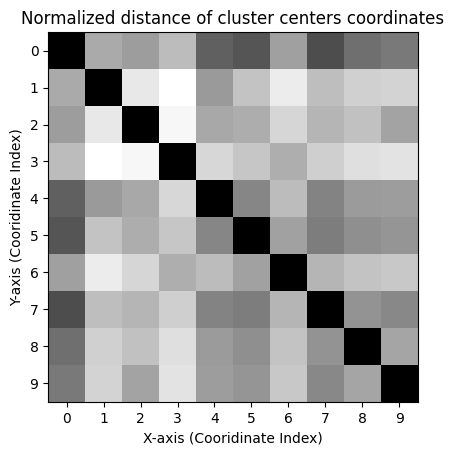

In [48]:
data = kmeans.cluster_centers_

# Calculate the L2 norms
norm_matrix = np.linalg.norm(data[:, np.newaxis, :] - data, axis=2)

w_min, w_max = norm_matrix.min(), norm_matrix.max()
norm_matrix_renorm = (norm_matrix - w_min) / (w_max - w_min)

plt.imshow(norm_matrix_renorm[:, :, np.newaxis], cmap="gray")

# Set x-axis and y-axis tick labels as pixel indices
plt.xticks(np.arange(10), np.arange(10))
plt.yticks(np.arange(10), np.arange(10))

# Add labels and title
plt.xlabel('X-axis (Cooridinate Index)')
plt.ylabel('Y-axis (Cooridinate Index)')
plt.title('Normalized distance of cluster centers coordinates')

# Show the plot
plt.show()

In [49]:
'''
this are not the real labels but just the dimension of the 10 clusters, 
as we can see the distribution is not the same so we can infer that the geometry
isn't optimal. This is also supported by the fact that the first cluster has a dimension
4 times the correct one.
'''

get_data_clusters(torch.tensor(k_means_labels))

[(0, torch.Size([2644])),
 (1, torch.Size([189])),
 (2, torch.Size([210])),
 (3, torch.Size([162])),
 (4, torch.Size([360])),
 (5, torch.Size([360])),
 (6, torch.Size([164])),
 (7, torch.Size([457])),
 (8, torch.Size([199])),
 (9, torch.Size([255]))]

In [50]:
'''
This high variance is an indicator that the clusters are unbalanced
'''

get_mean_and_std(torch.tensor(k_means_labels))

(tensor(759.8517), tensor(500.))

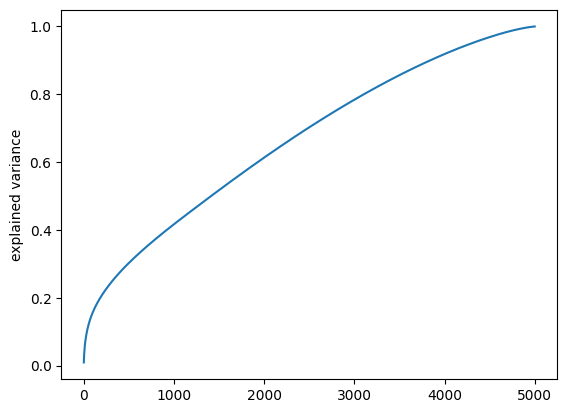

Explained variance of 10 components: 0.052136074751615524


In [51]:
'''
In this part we try to estimate how much variance is represented by
the first 10 components (of 5000)
'''

res_list = []
for i in range(1, len(kernel_pca_tot.eigenvalues_)):
  res_list.append(np.sum(kernel_pca_tot.eigenvalues_[:i])/np.sum(kernel_pca_tot.eigenvalues_))

plt.plot([*range(1, len(res_list) + 1)], res_list)
plt.ylabel('explained variance')
plt.show()

print(f'Explained variance of 10 components: {np.sum(kernel_pca.eigenvalues_)/np.sum(kernel_pca_tot.eigenvalues_)}')

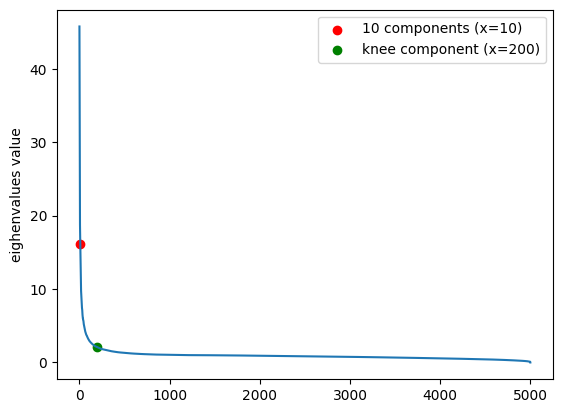

In [52]:
plt.plot([*range(1, len(kernel_pca_tot.eigenvalues_) + 1)], kernel_pca_tot.eigenvalues_)
plt.scatter(10, kernel_pca_tot.eigenvalues_[9], c='r', label='10 components (x=10)')
plt.scatter(200, kernel_pca_tot.eigenvalues_[199], c='g', label='knee component (x=200)')
plt.ylabel('eighenvalues value')
plt.legend()
plt.show()

### Section 3: (Supervised) classification

Consider the dataset composed of the original images, with the label assigned in the previous section (regardless of its actual match with the true label!). Then, define and learn a classifier that can predict the label of a new image. Speficically:

1. Learn a *kernel-SVM* on the data/label pairs. The choice of the kernel and its hyperparameters is up to your experimentation and time availability. Comment on your choices and results.

2. Learn a *fully-connected NN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability: show at least two different hyperparameter configurations, and comment on the results.

3. Learn a *CNN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability. Comment on the results with special respect to the FCN architecture.

In [53]:
'''
Device to use GPU acceleration
'''

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [54]:
'''
Create a pytorch dataset from the 5000 images sampled and assign the labels without
knowing about the true labels of the data
'''

x_np = x_np.reshape(x_np.shape[0], 1, 28, 28) # reshape because I saved it (5000, 784)

S_BATCH_SIZE = 256

unsupervised_dataset = torch.utils.data.TensorDataset(torch.tensor(x_np), torch.tensor(k_means_labels, dtype=torch.int64))
unsupervised_train_loader = torch.utils.data.DataLoader(unsupervised_dataset, batch_size=S_BATCH_SIZE, shuffle=True)

print(f'Transformed in tensors of type: {unsupervised_dataset.tensors[0].dtype} and {unsupervised_dataset.tensors[1].dtype}')

Transformed in tensors of type: torch.float32 and torch.int64


In [55]:
'''
Defition of the Support Vector Classifier, the Full Connected Network, and the Convolutional Neural Network
'''

svc = SVC(gamma=1/100)

class FCN(torch.nn.Module):
  def __init__(self):
    super(FCN, self).__init__()
    self.layer1 = torch.nn.Linear(28*28, 30*30)
    self.layer2 = torch.nn.Linear(30*30, 10)
    self.activation = torch.nn.ReLU()
    self.normalizeLayer = torch.nn.Softmax(dim=1)
  def forward(self, x):
    x = x.resize(x.size()[0], 28*28)
    x = self.layer1(x)
    x = self.activation(x)
    return self.normalizeLayer(self.layer2(x))

fcn = FCN().to(device)

class FCNTwo(torch.nn.Module):
  def __init__(self):
    super(FCNTwo, self).__init__()
    self.layer1 = torch.nn.Linear(28*28, 10)
    self.layer2 = torch.nn.Linear(10, 10)
    self.activation = torch.nn.ReLU()
    self.normalizeLayer = torch.nn.Softmax(dim=1)
  def forward(self, x):
    x = x.resize(x.size()[0], 28*28)
    x = self.layer1(x)
    x = self.activation(x)
    return self.normalizeLayer(self.layer2(x))

fcn_two = FCNTwo().to(device)

class FashionCNN(torch.nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # Convolution: BSx1x28x28 => BSx32x26x26
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool = torch.nn.MaxPool2d(3, stride=1)
        # BSx(26*26*32) => BSx128
        self.d1 = torch.nn.Linear(24 * 24 * 32, 128)
        # BSx128 => BSx10
        self.d2 = torch.nn.Linear(128, 10)
        self.activation = torch.nn.ReLU()
        self.lastActivation = torch.nn.Softmax(dim=1)

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)
        # Activation functions are (almost always) applied element-wise
        x = self.activation(x)
        x = self.pool(x)
        # print(x.size())
        # Flattening: BSx(32x26x26) => BSx(32*26*26)
        x = x.flatten(start_dim=1)
        # Linear layer, i.e. vanilla matrix multiplication:
        # BSx(32*26*26) => BSx128
        x = self.d1(x)
        x = self.activation(x)
        # Linear layer
        # BSx(32*26*26) => BSx128
        logits = self.d2(x)
        # Softmax computation
        out = self.lastActivation(logits)

        return out

fashionCNN = FashionCNN().to(device)

In [56]:
'''
This function returns a list of the loss values during training and trains the model
'''

def train_model(_model, _epochs, _trainloader, _loss, _optimizer):
  losses=[]
  for epoch in range(_epochs):
    _model.train()
    for x, y in iter(_trainloader):
        x = x.float()
        x = x.to(device)
        y = y.to(device)
        out=_model(x)
        l=_loss(out, y)
        _optimizer.zero_grad()
        l.backward()
        _optimizer.step()
        losses.append(l.item())
    print(f'Mean loss on epoch {epoch} is {np.mean(losses)}')
  
  return losses

In [57]:
'''
Training phase on the 5000 images dataset specified above
'''

svc.fit(x_np.reshape(x_np.shape[0], 28*28), k_means_labels)

fcn_losses = train_model(fcn, 20, unsupervised_train_loader,
            torch.nn.CrossEntropyLoss(),
            torch.optim.Adam(fcn.parameters(), lr=1e-3))

fcn_two_losses = train_model(fcn_two, 20, unsupervised_train_loader,
            torch.nn.CrossEntropyLoss(),
            torch.optim.Adam(fcn_two.parameters(), lr=1e-3))

fashionCNN_losses = train_model(fashionCNN, 20, unsupervised_train_loader, 
            torch.nn.CrossEntropyLoss(),
            torch.optim.Adam(fashionCNN.parameters(), lr=1e-3))

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Mean loss on epoch 0 is 1.902684897184372
Mean loss on epoch 1 is 1.872575396299362
Mean loss on epoch 2 is 1.8526028176148732
Mean loss on epoch 3 is 1.834504735469818
Mean loss on epoch 4 is 1.8207052230834961
Mean loss on epoch 5 is 1.8101731191078823
Mean loss on epoch 6 is 1.802084173474993
Mean loss on epoch 7 is 1.7958126403391361
Mean loss on epoch 8 is 1.79093618856536
Mean loss on epoch 9 is 1.7866353791952134
Mean loss on epoch 10 is 1.782707241448489
Mean loss on epoch 11 is 1.7795755416154861
Mean loss on epoch 12 is 1.7762885983173664
Mean loss on epoch 13 is 1.7733047864266804
Mean loss on epoch 14 is 1.7706662706534069
Mean loss on epoch 15 is 1.7684613965451716
Mean loss on epoch 16 is 1.766493071528042
Mean loss on epoch 17 is 1.764507108595636
Mean loss on epoch 18 is 1.762812352180481
Mean loss on epoch 19 is 1.761298798918724
Mean loss on epoch 0 is 2.0567051231861115
Mean loss on epoch 1 is 1.9952244192361832
Mean loss on epoch 2 is 1.9728764017422995
Mean loss on

### Section 4: Wrap-up!

Evaluate the overall accuracy of the pipeline on the *test set* of *FashionMNIST*. *I.e.* compare the predicted labels from the three classifiers built in *Section 3* with the true labels.

In order to assign a true label *name* (e.g. *trousers*, *sandal*, ...) to those determined just from *(kernel-)PCA* (that obviously carry no direct information about the subject of the picture), you can either:

i. *Cheat* and use the most abundant labels for each group of *(kernel-)PCA-labelled* datapoints.

ii. Sample a subset of datapoints from each *(kernel-)PCA-labelled* class, and assign one label by direct visual inspection. If you choose this route, it may also serve as a reminder of the fact that *expert labelling* is not always a trivial (and almost never a fast) task!

Comment on the results obtained.

In [58]:
'''
Returns the test accuracy NN: this is done by
1) predict the output with the model train above
2) In the batch we have get the highest probability value
3) Get the most freqent class in the cluster
4) Compare the two values
'''

def test_nn(fake_model):

  y_tens = torch.tensor(y_np).to(device)
  accuracies_list = []

  for x, y in testloader:
    x = x.float()
    x = x.to(device)
    y = y.to(device)
    out=fake_model(x) # 1)
    index_list = []

    cont = 0
    unsup_dataset_y = unsupervised_dataset.tensors[1].to(device)
    for i in torch.argmax(fcn(x), axis=1): # 2)
      index = torch.where(unsup_dataset_y == i) # 3)
      elements = y_tens[index] # 3)
      most_common_element, index_mce = torch.mode(elements) # 3)
      accuracies_list.append(1 if most_common_element == y[cont] else 0) # 4)
      cont+=1

  return np.average(accuracies_list)

In [59]:
'''
It's the same thing done above but the two libraries used are not
compatible so I had to re-implement the functions

Returns the test accuracy SVC: this is done by
1) predict the output with the model train above
2) In the batch we have get the highest probability value
3) Get the most freqent class in the cluster
4) Compare the two values
'''

def test_svc(fake_model):

  y_tens = torch.tensor(y_np).to(device)
  accuracies_list = []

  for x, y in testloader:
    x = x.reshape(x.size()[0], 28*28)
    x = x.to(device)
    y = y.to(device)
    x = x.cpu()
    out=fake_model.predict(x.numpy()) # 1)
    out = torch.tensor(out)
    out = out.to(device)

    cont = 0
    unsup_dataset_y = unsupervised_dataset.tensors[1].to(device)
    for i in out: # 2)
      index = torch.where(unsup_dataset_y == i) # 3)
      elements = y_tens[index] # 3)
      most_common_element, index_mce = torch.mode(elements) # 3)
      accuracies_list.append(1 if most_common_element == y[cont] else 0) # 4)
      cont+=1

  return np.average(accuracies_list)

In [60]:
print(f'SVC test accuracy: {test_svc(svc)}, FCN test accuracy: {test_nn(fcn)}, FCNTwo test accuracy: {test_nn(fcn_two)}, FCNN test accuracy: {test_nn(fashionCNN)}')

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


SVC test accuracy: 0.4041, FCN test accuracy: 0.2618, FCN test accuracy: 0.2618, FCNN test accuracy: 0.2618


### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.

In [61]:
'''
Full supervised learning
'''

fsm_svc = SVC(gamma=0.01)

fsm_fcn = FCN().to(device)

fsm_fcn_two = FCNTwo().to(device)

fsm_fashionCNN = FashionCNN().to(device)

fsm_svc.fit(x_np.reshape(x_np.shape[0], 28*28), y_np)

fcn_losses = train_model(fsm_fcn, 20, trainloader,
            torch.nn.CrossEntropyLoss(),
            torch.optim.Adam(fsm_fcn.parameters(), lr=1e-3))

fcn_two_losses = train_model(fsm_fcn_two, 20, trainloader,
            torch.nn.CrossEntropyLoss(),
            torch.optim.Adam(fsm_fcn_two.parameters(), lr=1e-3))

fashionCNN_losses = train_model(fsm_fashionCNN, 20, trainloader, 
            torch.nn.CrossEntropyLoss(),
            torch.optim.Adam(fsm_fashionCNN.parameters(), lr=1e-3))

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Mean loss on epoch 0 is 1.701486586514166
Mean loss on epoch 1 is 1.6758559851323145
Mean loss on epoch 2 is 1.6576627819551586
Mean loss on epoch 3 is 1.6441019202693035
Mean loss on epoch 4 is 1.6338973011000681
Mean loss on epoch 5 is 1.6257446778696136
Mean loss on epoch 6 is 1.6190794755413804
Mean loss on epoch 7 is 1.613664005267418
Mean loss on epoch 8 is 1.6091230506052854
Mean loss on epoch 9 is 1.6052578473495225
Mean loss on epoch 10 is 1.6015005155777895
Mean loss on epoch 11 is 1.5981787165342751
Mean loss on epoch 12 is 1.5951883304072483
Mean loss on epoch 13 is 1.5924972705633242
Mean loss on epoch 14 is 1.5899813115260022
Mean loss on epoch 15 is 1.587627423453634
Mean loss on epoch 16 is 1.5856105669783214
Mean loss on epoch 17 is 1.5836354206174106
Mean loss on epoch 18 is 1.5819109805878733
Mean loss on epoch 19 is 1.580196169574382
Mean loss on epoch 0 is 1.9416803656998327
Mean loss on epoch 1 is 1.8625531944177918
Mean loss on epoch 2 is 1.821981312191419
Mean l

In [62]:
'''
Returns the test accuracy of the NN
'''

def test_accuracy_nn(model):
  model.eval()
  correct = 0
  for x, y in testloader:
    x = x.float()
    x = x.to(device)
    y = y.to(device)
    out=model(x)
    correct+=(torch.argmax(out, axis=1)==y).sum()

  return correct/len(testloader.dataset)

In [63]:
'''
Returns the test accuracy of the SVC
'''

def test_accuracy_svc(model):
  correct = 0
  for x, y in testloader:
    x = x.reshape(x.size()[0], 28*28)
    x = x.float()
    x = x.to(device)
    y = y.to(device)
    x = x.cpu()
    out=model.predict(x.numpy())
    out = torch.tensor(out)
    out = out.to(device)
    correct+=(out==y).sum()

  return correct/len(testloader.dataset)

In [64]:
print(f'SVC test accuracy: {test_accuracy_svc(fsm_svc)}, FCN test accuracy: {test_accuracy_nn(fsm_fcn)}, FCNTwo test accuracy: {test_accuracy_nn(fsm_fcn_two)}, FCNN test accuracy: {test_accuracy_nn(fsm_fashionCNN)}')

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


SVC test accuracy: 0.8072999715805054, FCN test accuracy: 0.8795999884605408, FCNTwo test accuracy: 0.7836999893188477, FCNN test accuracy: 0.901199996471405


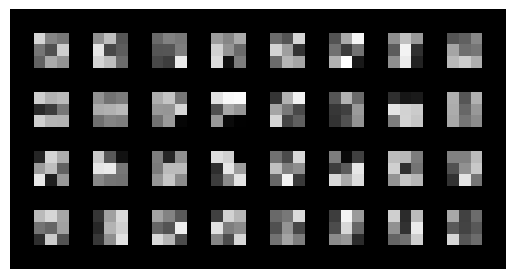

In [65]:
w = fsm_fashionCNN.conv1.weight.detach().cpu()

w_min, w_max = w.min(), w.max()
plt_weights = (w - w_min) / (w_max - w_min)

imshow(torchvision.utils.make_grid(plt_weights))

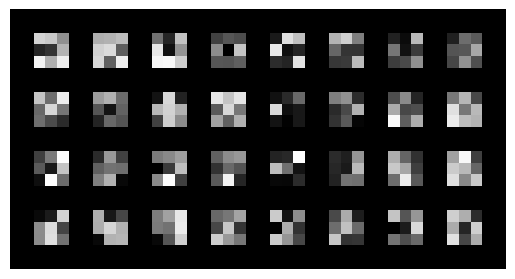

In [66]:
w = fashionCNN.conv1.weight.detach().cpu()

w_min, w_max = w.min(), w.max()
plt_weights = (w - w_min) / (w_max - w_min)

imshow(torchvision.utils.make_grid(plt_weights))

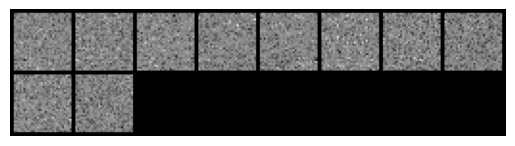

In [67]:
# Extracting weights
weights = fsm_fcn.layer2.weight.detach().cpu()

# Normalization
w_min, w_max = weights.min(), weights.max()
plt_weights = (weights - w_min) / (w_max - w_min)

# Plot
plt_weights = plt_weights.reshape(plt_weights.shape[0], -1, 30, 30)
imshow(torchvision.utils.make_grid(plt_weights))

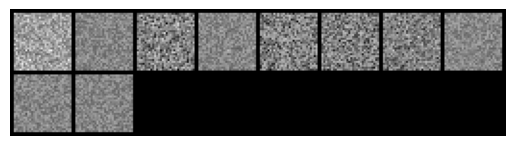

In [68]:
# Extracting weights
weights = fcn.layer2.weight.detach().cpu()

# Normalization
w_min, w_max = weights.min(), weights.max()
plt_weights = (weights - w_min) / (w_max - w_min)

# Plot
plt_weights = plt_weights.reshape(plt_weights.shape[0], -1, 30, 30)
imshow(torchvision.utils.make_grid(plt_weights))